Load necessary libraries.

In [1379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1385]:
### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### ML packages
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

Load dataset.

In [1381]:
df = pd.read_csv('00_authors.csv').rename(columns={'Unnamed: 0': 'Author'}).drop(columns='BookID')
authors = df['Author'].values  # n_samples-length array
X = df.drop(columns=['Author'])

**EM Algorithm for Multivariate Gaussian Mixture Model**

Let the density of $x \in \mathbb{R}^d$ be: $p(x) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x \mid \mu_k, \Sigma_k)$

where:
- $\pi_k$ are the mixing proportions (with $\sum_k \pi_k = 1$),
- $\mu_k \in \mathbb{R}^d$ is the mean of component $k$,
- $\Sigma_k \in \mathbb{R}^{d \times d}$ is the covariance matrix.

**E-step**

$\gamma_{ik} = \frac{ \pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k) }{ \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j) }$ where $\mathcal{N}(x \mid \mu, \Sigma)$ is the multivariate Gaussian density: $\mathcal{N}(x \mid \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$

**M-step**

Effective number of points (soft cluster count): $N_k = \sum_{i=1}^{N} \gamma_{ik}$

Update mean: $\mu_k = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} x_i$

Update covariance: $\Sigma_k = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T$

Update mixing weights: $\pi_k = \frac{N_k}{N}$

Repeat E-step and M-step until convergence (e.g., change in log-likelihood is below a threshold).


In [ ]:
num_iterations = 50
K = 4  # number of clusters
allow_singular = True # combat error if cov is non-singular; can turn off.

epsilon = 1e-6  # regularization constant
X_array = X.to_numpy()
n_rows, n_cols = X.shape

# Initialization
means = X.sample(n=K).to_numpy() # Randomly sample K observations
shared_cov = np.cov(X_array, rowvar=False, ddof=1)
cov = [shared_cov.copy() for _ in range(K)] # Sample covariance matrix
pis = [1/K] * K # Split evenly across K clusters
gamma = np.zeros((n_rows, K))

pis_dict = {'Initial': [pis.copy()]}
pis_dict.update({f'Iteration_{i}': [] for i in range(num_iterations)})

for iter in range(num_iterations):
    # E-step (EXPECTATION)
    for i in range(n_rows):
        xi = X.iloc[i].values
        denom = 0
        for k in range(K):
            numerator = pis[k] * multivariate_normal.pdf(xi, mean=means[k], cov=cov[k], allow_singular=allow_singular)
            gamma[i, k] = numerator
            denom += numerator
        gamma[i, :] /= denom  

    # M-step (MAXIMIZATION)
    Nk =  [np.sum(gamma[:, j]) for j in range(K)] # List of K weights for each cluster
    means = [np.sum([gamma[i, k] * X_array[i,:] for i in range(n_rows)], axis = 0) / Nk[k] for k in range(K)] # List of K mean vectors
    cov = [np.sum([gamma[i, k] * np.outer(X_array[i, :] - means[k], X_array[i, :] - means[k]) for i in range(n_rows)], axis=0) / Nk[k] + epsilon * np.eye(n_cols) for k in range(K)] # List of K cov matrix w/ dimensions pxp
    pis = np.array(Nk)/n_rows

    pis_dict[f'Iteration_{iter}'].append(pis.copy())


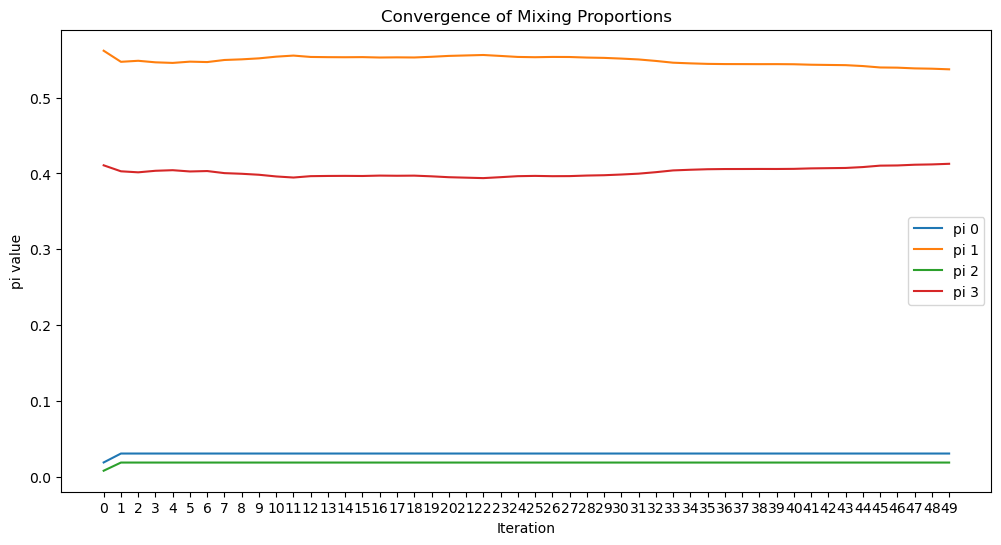

In [1384]:
iterations = [key for key in pis_dict if key.startswith('Iteration_')]
iterations_sorted = sorted(iterations, key=lambda x: int(x.split('_')[1]))

pi_matrix = np.array([pis_dict[it][0] for it in iterations_sorted])  # shape: (iterations, K)

plt.figure(figsize=(12, 6))
for k in range(pi_matrix.shape[1]):
    plt.plot(range(len(pi_matrix)), pi_matrix[:, k], label=f'pi {k}')

plt.title('Convergence of Mixing Proportions')
plt.xlabel('Iteration')
plt.ylabel('pi value')
plt.xticks(range(len(iterations_sorted)))
plt.legend()
plt.show()


# Msc

**EM Algorithm - Univariate Gaussian**

This example is from the elements of statistics textbook; I wanted to try working on the univariate before applying to our dataset!

Data = [-0.39, 0.12, 0.94, 1.67, 1.76, 2.44, 3.72, 4.28, 4.92, 5.53, 0.06, 0.48, 1.01, 1.68, 1.8, 3.25, 4.12, 4.6, 5.28, 6.22]

Final Params -> u1 = 4.6559128079788765, u2 = 1.0831618077390606, var1 = 0.8187935704379321, var2 = 0.8113706189175555, pi = 0.5545902325255461


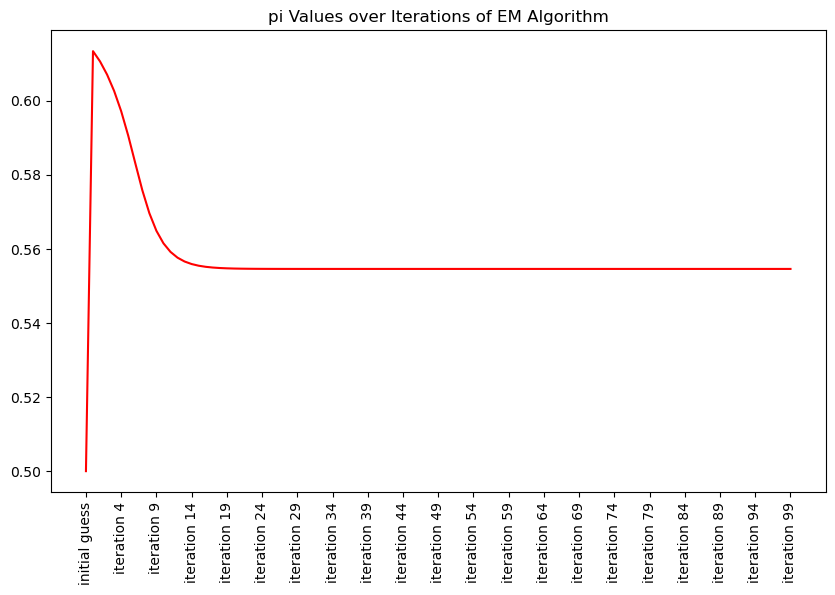

In [1386]:
data = "-0.39 0.12 0.94 1.67 1.76 2.44 3.72 4.28 4.92 5.53 0.06 0.48 1.01 1.68 1.80 3.25 4.12 4.60 5.28 6.22"
data = data.split(' ')
data = [float(data[i]) for i in range(len(data))]
print(f'Data = {data}\n')

rand_int = np.random.randint(0,len(data),2)

# Initial Param Guess
u1 = data[rand_int[0]]
u2 = data[rand_int[1]]
var1 = np.var(data, ddof=1)
var2 = np.var(data, ddof=1)
pi = 0.5

n = len(data)
y = data

M_sims = 100
pi_dict = {'initial guess': 0.5}
pi_dict.update({f'iteration {j}': [] for j in range(M_sims)})
gamma_dict = {f'iteration {j}':[] for j in range(M_sims)}
for j in range(M_sims):
    for i in range(len(data)):
        yi = data[i]
        numerator = pi * (1/np.sqrt(2 * np.pi * var2)) * np.exp((-1/(2*var2)) * (yi - u2)**2)
        denominator = (1 - pi) * (1/np.sqrt(2 * np.pi * var1)) * np.exp((-1/(2*var1)) * (yi - u1)**2) + numerator
        gamma_i = numerator/denominator
        gamma_dict[f'iteration {j}'].append(gamma_i)

    gamma = gamma_dict[f'iteration {j}']
    u1 = np.sum([(1 - gamma[i]) * (y[i]) for i in range(n)]) / np.sum([1 - gamma[i] for i in range(n)])
    u2 = np.sum([(gamma[i] * (y[i])) for i in range(n)]) / np.sum([gamma[i] for i in range(n)])
    var1 = np.sum([(1-gamma[i])*(y[i]-u1)**2 for i in range(n)]) / np.sum([1-gamma[i] for i in range(n)])
    var2 = np.sum([(gamma[i])*(y[i]-u2)**2 for i in range(n)]) / np.sum([gamma[i] for i in range(n)])
    pi = np.sum([gamma[i] for i in range(n)]) / n

    pi_dict[f'iteration {j}'].append(pi)

print(f'Final Params -> u1 = {u1}, u2 = {u2}, var1 = {var1}, var2 = {var2}, pi = {list(pi_dict.values())[-1][0]}')

pi_vals = [0.5]+ [list(pi_dict.values())[i][0] for i in range(1,len(list(pi_dict.values())))]
plt.figure(figsize=(10,6))
plt.plot(list(pi_dict.keys()),pi_vals, color = 'red')
plt.title('pi Values over Iterations of EM Algorithm')
xticks = list(pi_dict.keys())[::5]
plt.xticks(xticks, rotation=90)
plt.show()